In [99]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import os
from liams_funcs import *

from cellpose import models, io
from mahotas.features import haralick

In [2]:
control_dir = '../control_images/'
penetramax_dir = '../penetramax_images/'

control_fnames = [control_dir + fname for fname in os.listdir(control_dir)]
penetramax_fnames = [penetramax_dir + fname for fname in os.listdir(penetramax_dir)]

In [3]:
fname1 = '../control_images/001_z26.png'
fname2 = '../penetramax_images/011_z57.png'

In [74]:
def normalise(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def gaussian_normalisation(arr):
    from numpy import nanmean, nanstd
    return (arr - nanmean(arr)) / nanstd(arr)

def quantile_normalisation(arr):
    from numpy import quantile
    return (arr - quantile(arr, 0.5)) / (quantile(arr, 0.75) - quantile(arr, 0.25))

In [5]:
data = np.load('../segments/control/001_z26.png.npy')
image = io.imread('../control_images/001_z26.png')

reds, blues = image[:,:,0], image[:,:,2]
combined_cells, combined_nuclei = data[:,:,0], data[:,:,1]

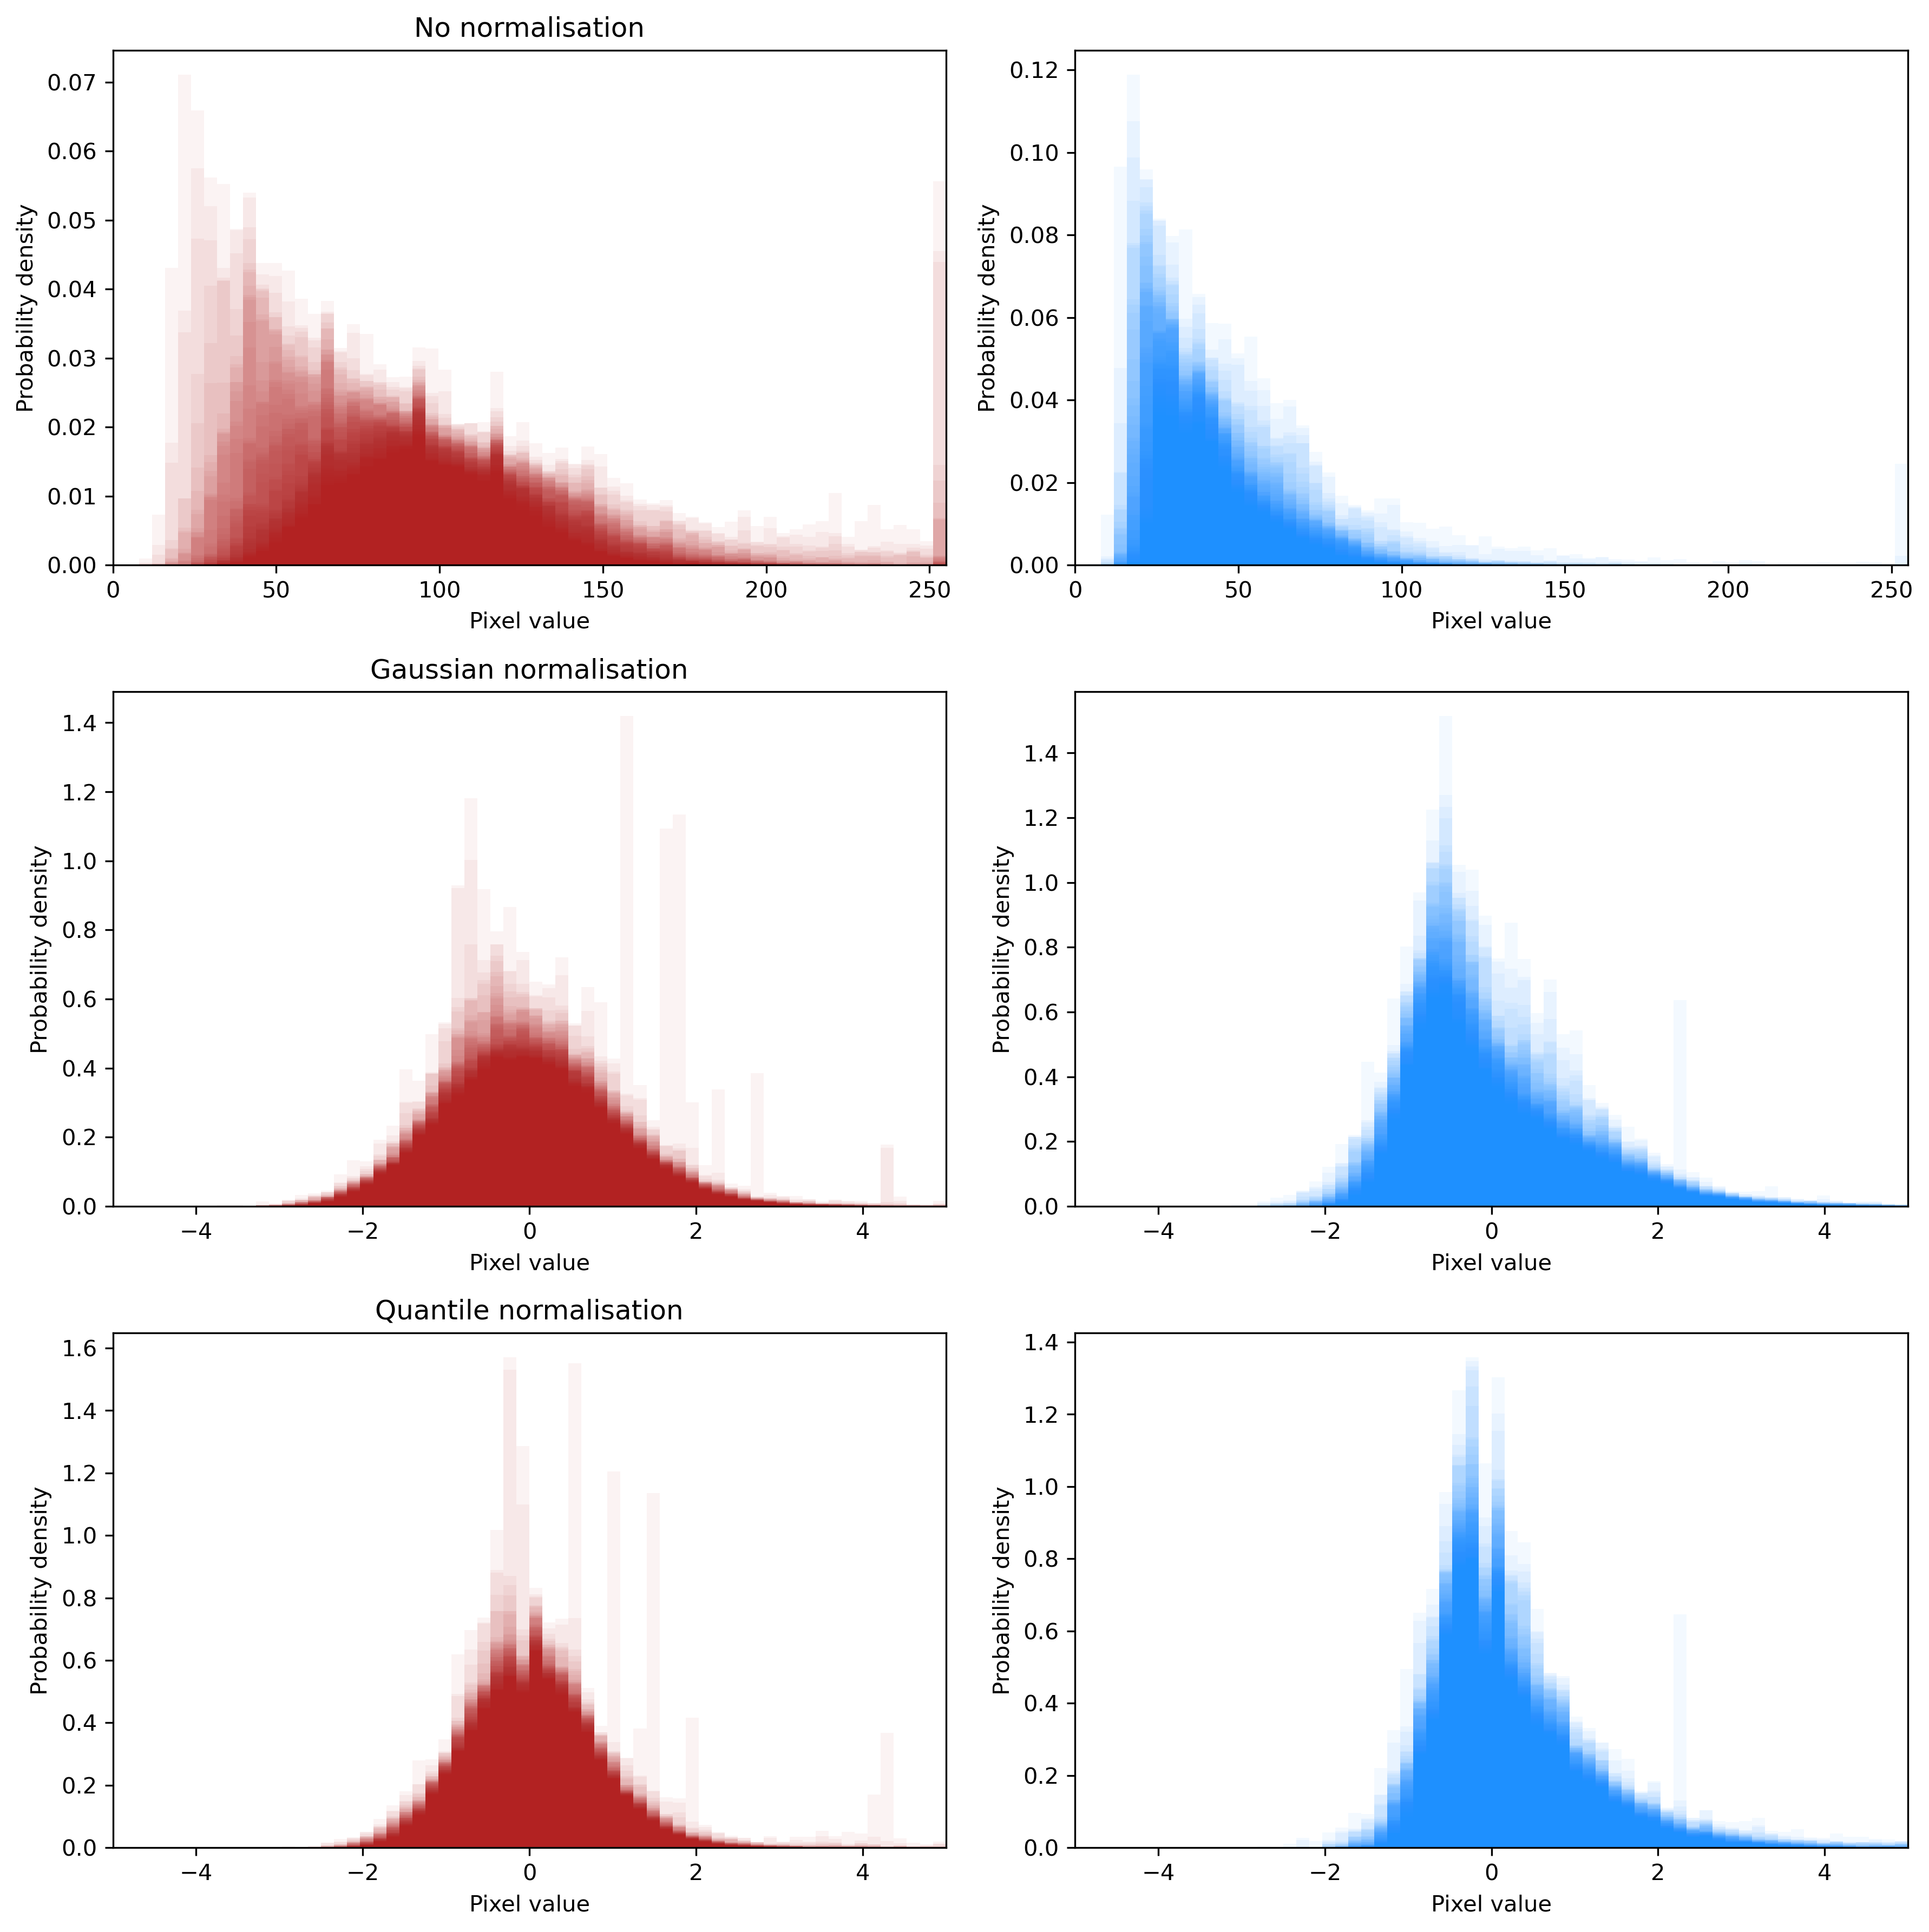

In [145]:
vals = np.arange(1, combined_nuclei.max()+1)
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=300)

for val in vals:
    mask = (combined_nuclei == val)
    red = reds[mask]
    blue = blues[mask]

    counts_red, edges = np.histogram(red, bins=64, range=(0,255), density=True)
    counts_blue, _ = np.histogram(blue, bins=64, range=(0,255), density=True)

    axes[0,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[0,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(gaussian_normalisation(red), bins=64, range=(-5,5), density=True)
    counts_blue, _= np.histogram(gaussian_normalisation(blue), bins=64, range=(-5,5), density=True)

    axes[1,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[1,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(quantile_normalisation(red), bins=64, range=(-5,5), density=True)
    counts_blue, _ = np.histogram(quantile_normalisation(blue), bins=64, range=(-5,5), density=True)

    axes[2,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[2,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

for ax in axes.flatten():
    ax.set_ylim(0)
    ax.set_ylabel('Probability density')
    ax.set_xlabel('Pixel value')

axes[0,0].set_xlim(0, 255); axes[0,1].set_xlim(0, 255)
axes[1,0].set_xlim(-5, 5); axes[1,1].set_xlim(-5, 5); axes[2,0].set_xlim(-5, 5); axes[2,1].set_xlim(-5, 5)
axes[0,0].set_title('No normalisation'); axes[1,0].set_title('Gaussian normalisation'); axes[2,0].set_title('Quantile normalisation')

plt.tight_layout()
plt.savefig('../figures/spectrum_normalisations.png', dpi=300, bbox_inches='tight')
plt.show()

In [337]:
def segmental_correction(image, masks, flux_normalisation=gaussian_normalisation):
    from liams_funcs import decompose_masks
    from numpy import stack, nan, ones_like

    R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
    R1, G1 ,B1 = nan * ones_like(R), nan * ones_like(G), nan * ones_like(B)
    for mask in decompose_masks(masks, reduce=False):
        R1[mask] = flux_normalisation(R[mask])
        G1[mask] = flux_normalisation(G[mask])
        B1[mask] = flux_normalisation(B[mask])

    return stack([R1 ,G1, B1], axis=2)

def erodeNtimes(mask, N=1):
    from skimage.morphology import binary_erosion
    if N == 1: return binary_erosion(mask)
    return erodeNtimes(binary_erosion(mask), N=N-1)

def ZtoRGB(channel, offset:int=1, min=None, max=None):
    from numpy import uint8, nanmax, nanmin, where, isfinite
    if min is None: min = nanmin(channel)
    if max is None: max = nanmax(channel)
    return uint8(where(isfinite(channel), offset + (255-offset) * (channel - min) / (max - min), 0))

class Segment:
    def __init__(self, cell_rp, nucleus_rp, segment_order:int=0, min=None, max=None):
        from numpy import where, nan, int16

        self.cell_rp = cell_rp
        self.nucleus_rp = nucleus_rp
        self.segment_order = segment_order

        # Colour channels
        self.cellR = where(self.cell_rp.image, self.cell_rp.intensity_image[:,:,0], nan)
        self.cellB = where(self.cell_rp.image, self.cell_rp.intensity_image[:,:,2], nan)
        self.nucleusR = where(self.nucleus_rp.image, self.nucleus_rp.intensity_image[:,:,0], nan)
        self.nucleusB = where(self.nucleus_rp.image, self.nucleus_rp.intensity_image[:,:,2], nan)

        # Haralick features
        from mahotas.features import haralick

        self.haralickR = haralick(ZtoRGB(self.nucleusR, min=min, max=max), ignore_zeros=True).mean(0)
        self.haralickB = haralick(ZtoRGB(self.nucleusB, min=min, max=max), ignore_zeros=True).mean(0)

    def show_segments(self, crange=5):
        from matplotlib.pyplot import subplots, tight_layout, show, colorbar

        vmin, vmax = -crange, crange
        fig, axes = subplots(2, 2, figsize=(12,8), dpi=300)
        
        im = axes[0,0].imshow(self.cellR, origin='lower', extent=self.cell_rp.bbox, 
                              cmap='Reds', vmin=vmin, vmax=vmax)
        colorbar(im, ax=axes[0,0], label='Cell redness', shrink=0.7)
        im = axes[0,1].imshow(self.cellB, origin='lower', extent=self.cell_rp.bbox, 
                              cmap='Blues', vmin=vmin, vmax=vmax)
        colorbar(im, ax=axes[0,1], label='Cell blueness', shrink=0.7)
        im = axes[1,0].imshow(self.nucleusR, origin='lower', extent=self.nucleus_rp.bbox, 
                              cmap='Reds', vmin=vmin, vmax=vmax)
        colorbar(im, ax=axes[1,0], label='Nucleus redness', shrink=0.7)
        im = axes[1,1].imshow(self.nucleusB, origin='lower', extent=self.nucleus_rp.bbox, 
                              cmap='Blues', vmin=vmin, vmax=vmax)
        colorbar(im, ax=axes[1,1], label='Nucleus blueness', shrink=0.7)

        tight_layout()
        show()

    ### Regionprops
        
    def getNucleusArea(self): return self.nucleus_rp.area
    def getCellArea(self): return self.cell_rp.area

    def getNucleusAreaBbox(self): return self.nucleus_rp.area_bbox
    def getCellAreaBbox(self): return self.cell_rp.area_bbox

    def getNucleusAreaConvex(self): return self.nucleus_rp.area_convex
    def getCellAreaConvex(self): return self.cell_rp.area_convex

    def getNucleusAxisMajor(self): return self.nucleus_rp.axis_major_length
    def getCellAxisMajor(self): return self.cell_rp.axis_major_length

    def getNucleusAxisMinor(self): return self.nucleus_rp.axis_minor_length
    def getCellAxisMinor(self): return self.cell_rp.axis_minor_length

    def getNucleusEcc(self): return self.nucleus_rp.eccentricity
    def getCellEcc(self): return self.cell_rp.eccentricity

    def getNucleusDiam(self): return self.nucleus_rp.equivalent_diameter_area
    def getCellDiam(self): return self.cell_rp.equivalent_diameter_area

    def getNucleusFeretDiam(self): return self.nucleus_rp.feret_diameter_max
    def getCellFeretDiam(self): return self.cell_rp.feret_diameter_max

    def getNucleusMaxR(self): return self.nucleusR[self.nucleus_rp.image].max()
    def getCellMaxR(self): return self.cellR[self.cell_rp.image].max()

    def getNucleusMinR(self): return self.nucleusR[self.nucleus_rp.image].min()
    def getCellMinR(self): return self.cellR[self.cell_rp.image].min()

    def getNucleusStdR(self): return self.nucleusR[self.nucleus_rp.image].std()
    def getCellStdR(self): return self.cellR[self.cell_rp.image].std()

    def getNucleusSolidity(self): return self.nucleus_rp.solidity
    def getCellSolidity(self): return self.cell_rp.solidity

    def getNucleusOri(self): return self.nucleus_rp.orientation
    def getCellOri(self): return self.cell_rp.orientation

    def getNucleusPerim(self): return self.nucleus_rp.perimeter
    def getCellPerim(self): return self.cell_rp.perimeter

    ### Haralick
    from mahotas.features import haralick

    def getHiR(self, i:int): return self.haralickR[i]
    def getHiB(self, i:int): return self.haralickB[i]

    ### Custom 
    from math import pi

    def getNucleusRoundness(self, normalisation=4*pi): return self.nucleus_rp.area / (normalisation * self.nucleus_rp.perimeter)
    def getCellRoundness(self, normalisation=4*pi): return self.cell_rp.area / (normalisation * self.cell_rp.perimeter)

    def getNucleusFraction(self): return self.nucleus_rp.area / self.cell_rp.area

    def getSegmentOrder(self): return self.segment_order
    
    def getEnergyR(self): return (self.nucleusR[self.nucleus_rp.image]**2).sum()
    def getEnergyB(self): return (self.nucleusB[self.nucleus_rp.image]**2).sum()

    def getEdgeFluxR(self, N=5): return self.nucleusR[erodeNtimes(self.nucleus_rp.image, N=N)].mean() / self.nucleusR[self.nucleus_rp.image].mean()

class Masks:
    def __init__(self, fname, type='control', flux_normalisation=gaussian_normalisation, min=None, max=None):
        from cellpose.io import imread
        from numpy import load, arange, meshgrid
        from skimage.measure import regionprops
        
        if type == 'control':
            image_dir = '../control_images/'
            mask_dir = '../segments/control/'

        # Load image and its masks
        self.image = imread(image_dir + fname)
        data = load(mask_dir + fname + '.npy')
        self.cells, self.nuclei = data[:,:,0], data[:,:,1]
        self.mask_vals = arange(1, self.cells.max()+0.5)

        # Correct images
        self.cell_images = segmental_correction(self.image, self.cells, flux_normalisation=flux_normalisation)
        self.nucleus_images = segmental_correction(self.image, self.nuclei, flux_normalisation=flux_normalisation)

        # Pixel coordinates
        self.xg, self.yg = meshgrid(arange(self.image.shape[0]), arange(self.image.shape[1]))

        # Genprops
        self.cell_regionprops = regionprops(self.cells, self.cell_images)
        self.nucleus_regionprops = regionprops(self.nuclei, self.nucleus_images)

        self.segments = []
        for cell_rp, nucleus_rp in zip(self.cell_regionprops, self.nucleus_regionprops):
            self.segments.append(Segment(cell_rp, nucleus_rp, min=min, max=max))

In [342]:
m = Masks('001_z26.png', type='control', min=-5, max=2)

In [354]:
mask = m.segments[2]
R = ZtoRGB(mask.nucleusR, min=-5, max=5)
print(mask.nucleus_rp.centroid)
mask.haralickR, mask.haralickB

(225.88186462324393, 648.9785014899958)


(array([ 6.85356832e-04,  1.43088651e+03,  4.14198735e-01,  1.22269289e+03,
         7.42912237e-02,  3.40329751e+02,  3.45988507e+03,  7.34881736e+00,
         1.10742030e+01,  1.02603365e-04,  5.42552607e+00, -1.87099069e-01,
         9.47711355e-01]),
 array([ 6.50937126e-03,  3.14968266e+03,  5.93423136e-02,  1.67425705e+03,
         9.48654553e-02,  3.51314836e+02,  3.54734554e+03,  5.43129809e+00,
         7.74657593e+00,  2.65685993e-04,  4.25097939e+00, -2.76832937e-02,
         4.41964474e-01]))

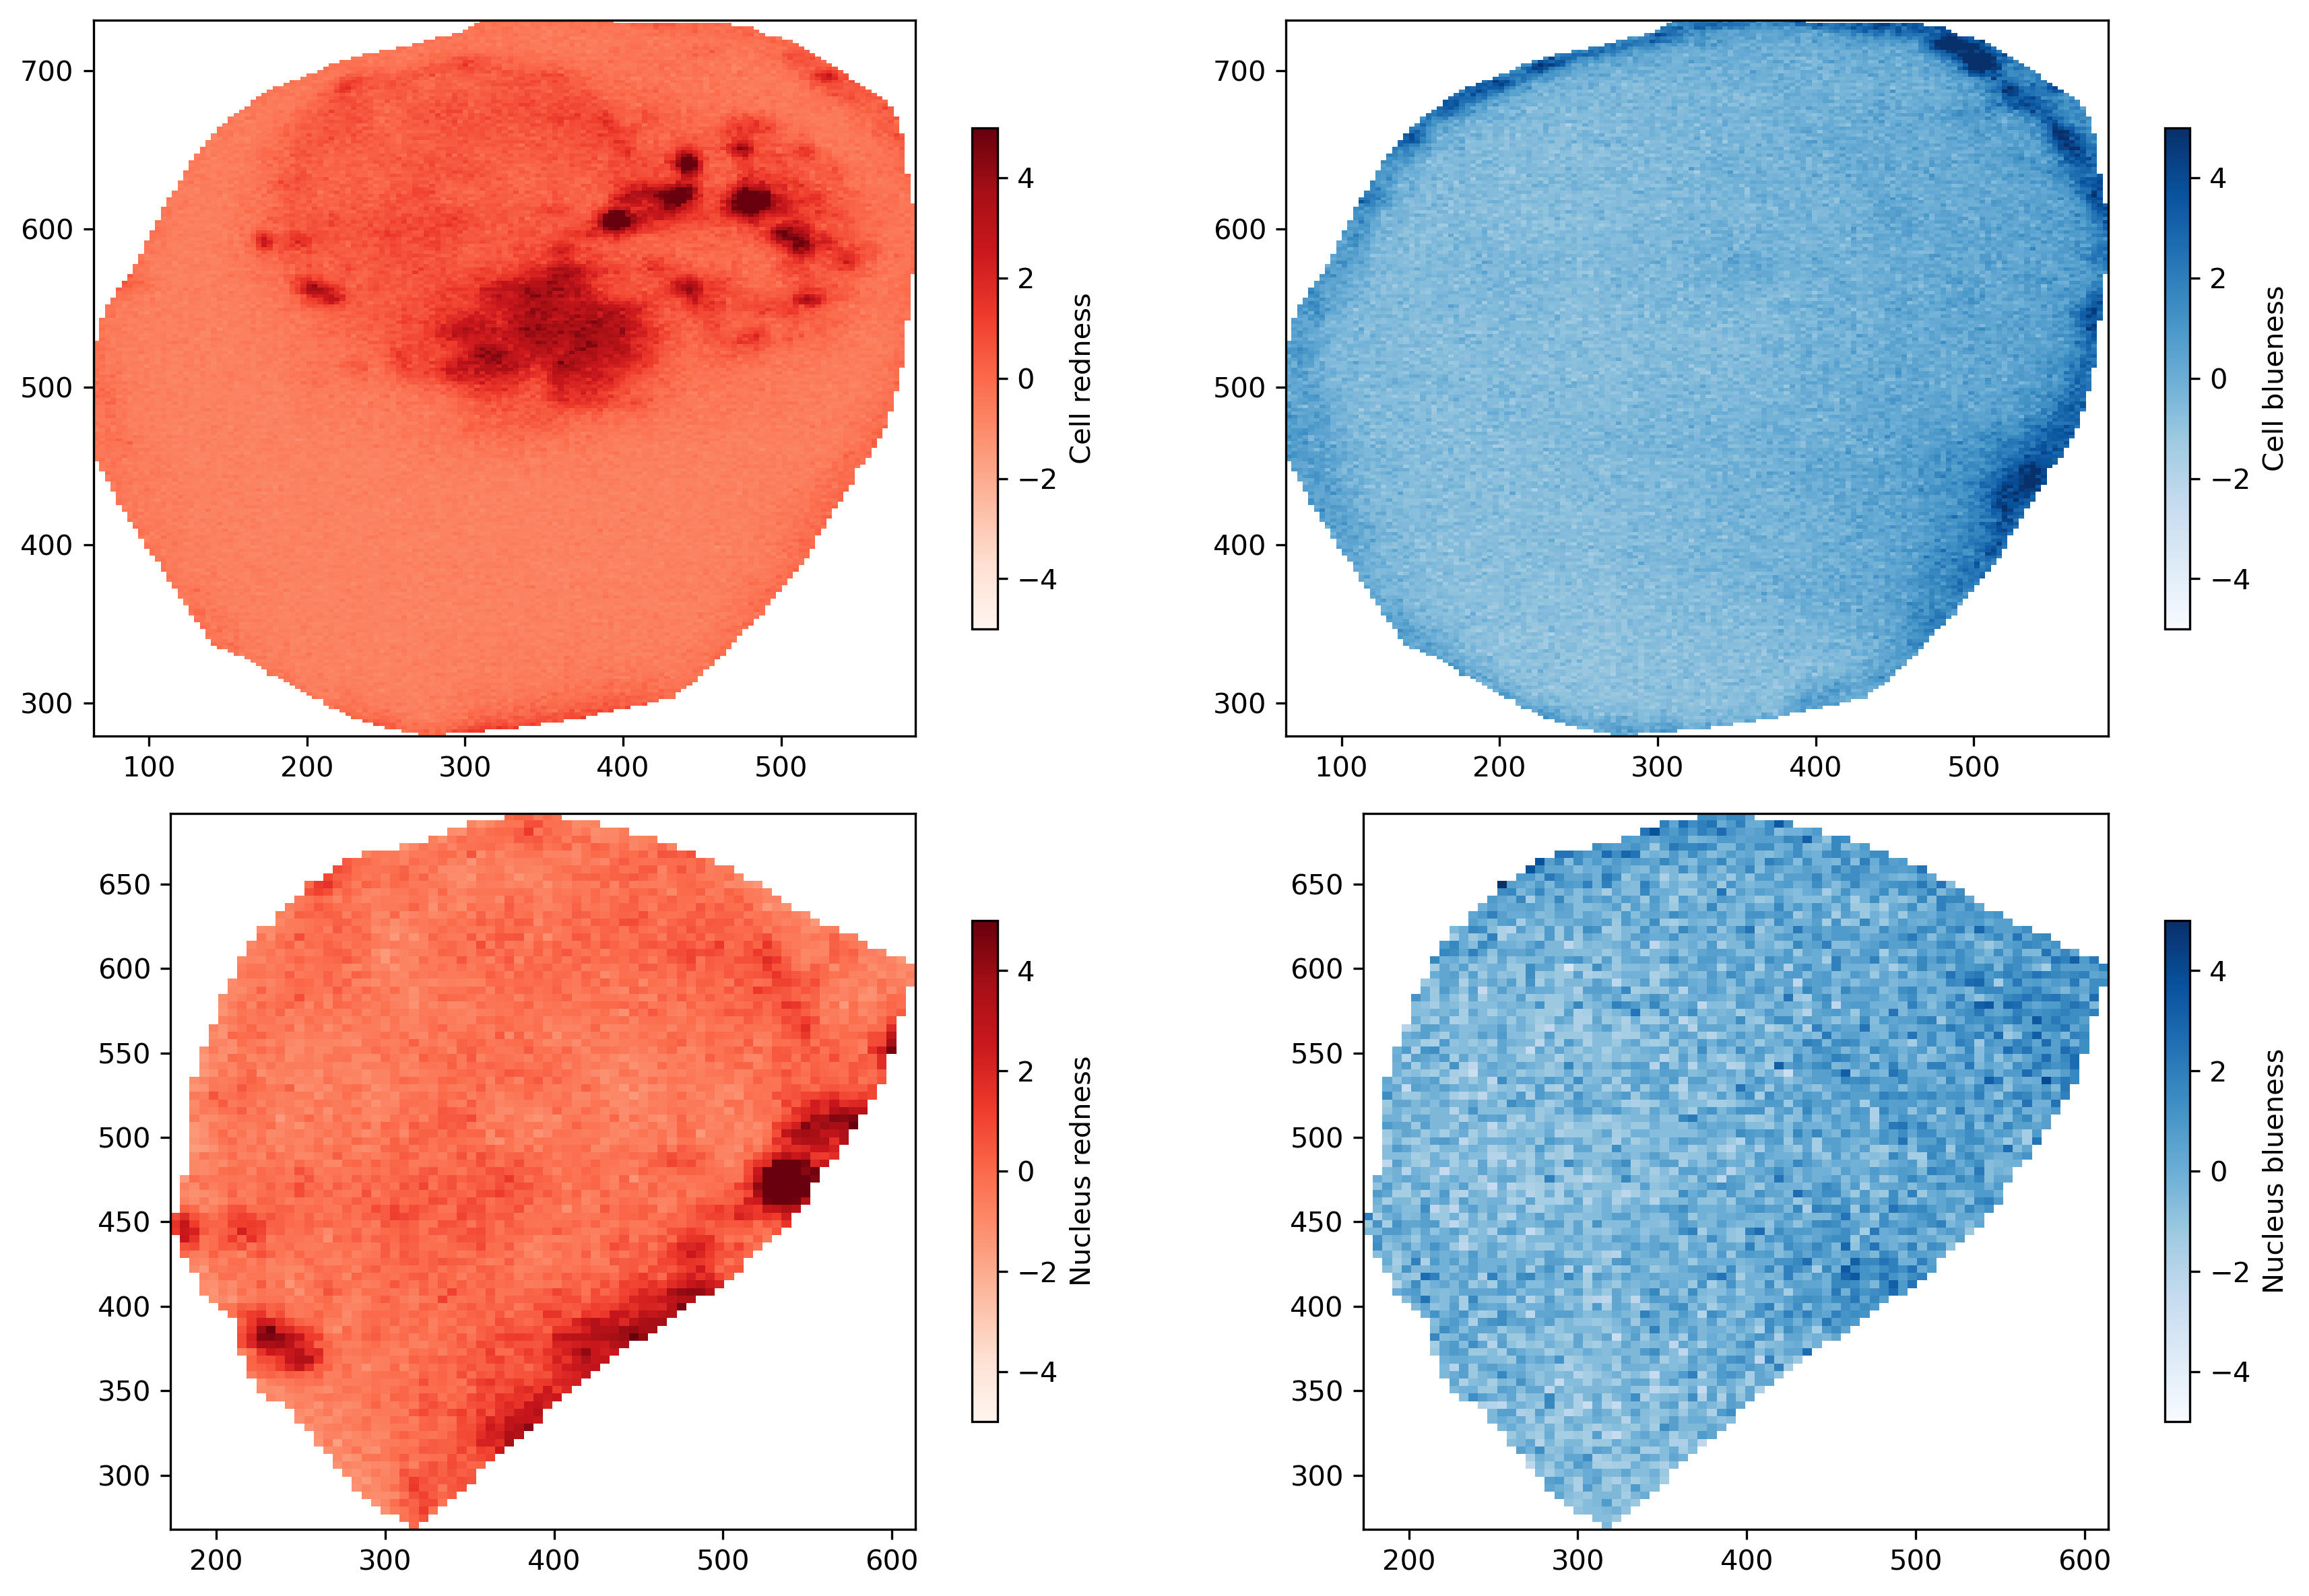

In [355]:
m.segments[2].show_segments(crange=5)

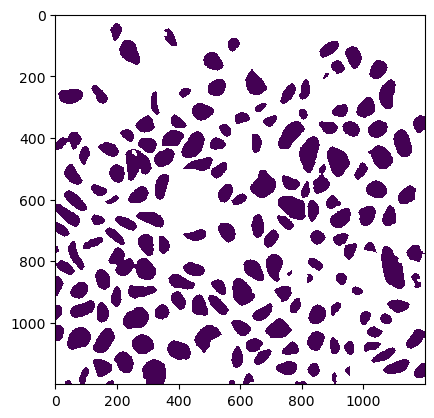

In [184]:
reds = io.imread('../control_images/001_z26.png')[:,:,0]
nuclei = (np.load('../segments/control/001_z26.png.npy')[:,:,1])

plt.imshow(np.where(nuclei, 1, np.nan))

In [170]:
from skimage.measure import regionprops

In [277]:
corrected_image = segmental_correction(image, nuclei)

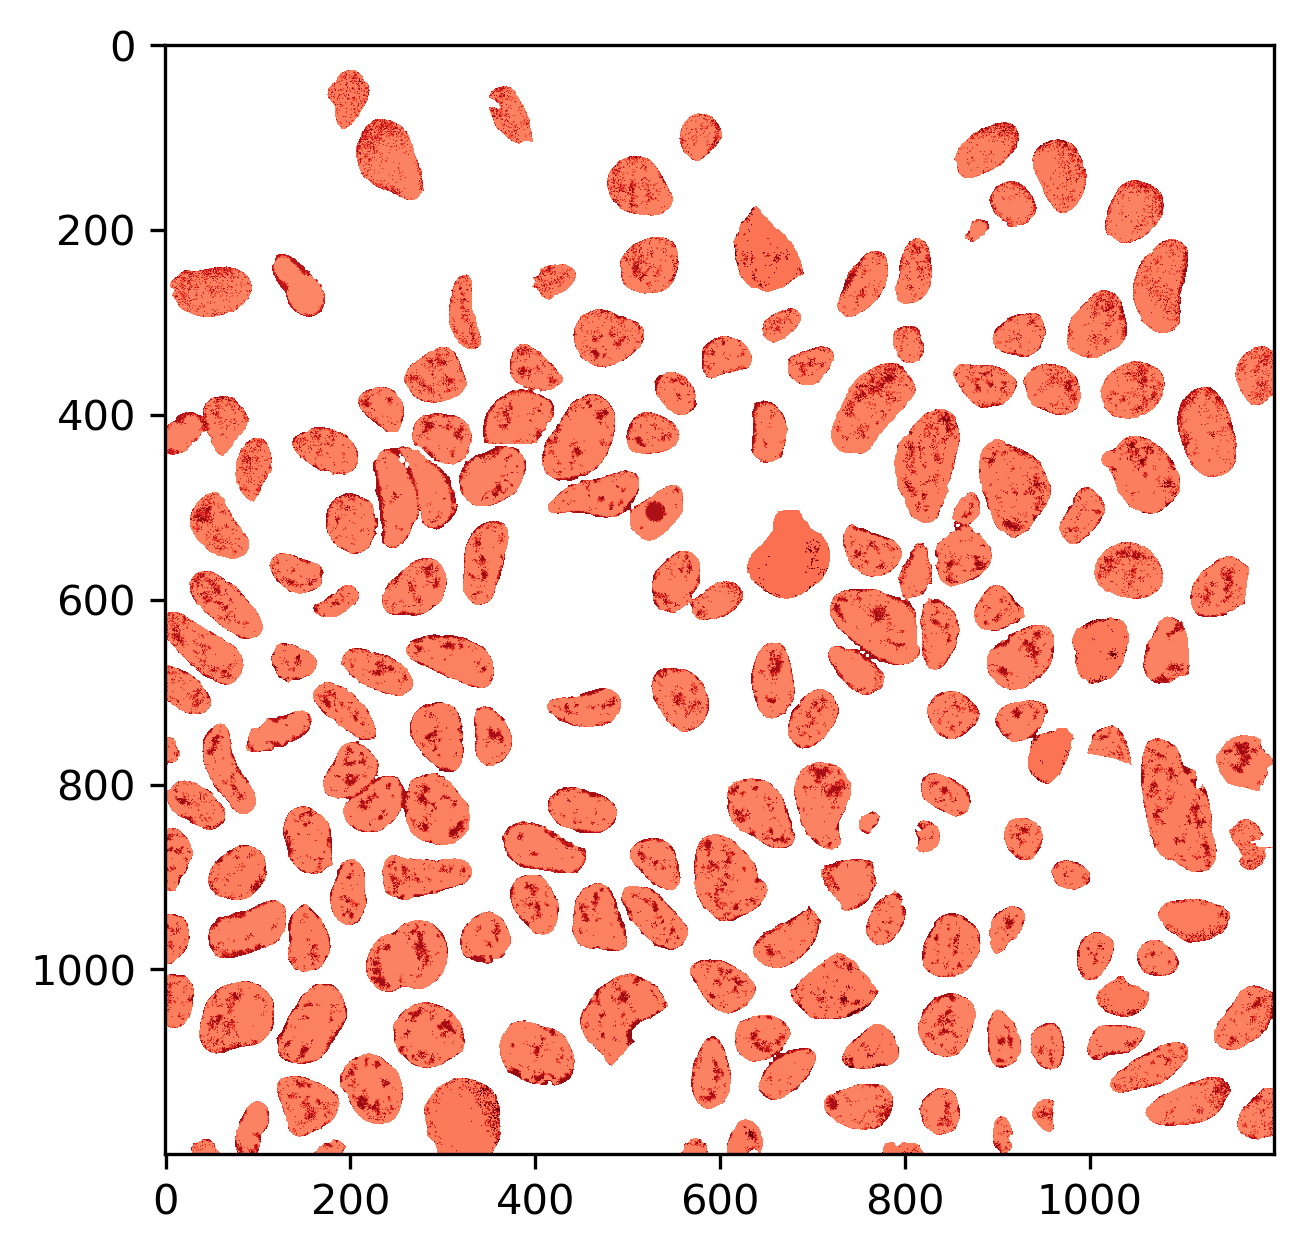

In [199]:
plt.figure(dpi=300)
plt.imshow(corrected_image[:,:,0], vmin=-3, vmax=3, cmap='Reds')

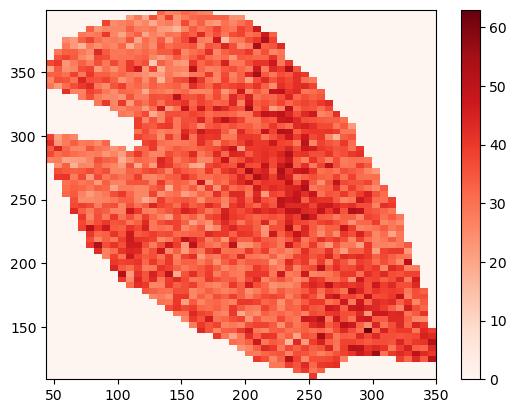

In [282]:
rp = regionprops(nuclei, reds)[0]

plt.imshow(rp.intensity_image, cmap='Reds', extent=rp.bbox)
plt.colorbar()

In [284]:
haralick(rp.intensity_image).mean(0)

array([ 1.00970586e-01,  1.01225853e+02,  8.30586718e-01,  2.98914219e+02,
        4.04105560e-01,  4.56355347e+01,  1.09443102e+03,  4.81451059e+00,
        7.22849144e+00,  2.06121783e-03,  3.84287265e+00, -2.16426961e-01,
        9.08799217e-01])

In [ ]:
plt.imshow()